<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/Neural_Network_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time

df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')
print(df.shape[0])

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']

8750


In [2]:
X_modified = X.drop(['n/m', 'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n'], axis=1)
print(X_modified.head())
#X_modified = X.drop(['max', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', '(m/n)^2', '(m/n)^3', 'class', 'av.length'], axis = 1)

     n   m   av.length     std.dev  median  range  max    k
0  160  40  390.706238  129.514984   381.5    479  639  138
1  144  32   99.159721   17.970320   101.5     94  140   62
2   60  24  221.233337   61.493938   227.5    256  349   50
3  200  20   49.150002   28.459570    50.0     99  100   88
4  126  28  311.658722  108.548103   306.5    367  496  111


In [3]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow
from tensorflow import keras 


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,1))
    return 99999*1/(1+K.exp(-x))

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(16, activation = 'relu'))

    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(16, activation = 'relu'))

    model.add(Dense(32, activation='relu'))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(16, activation='relu'))
    
    model.add(Dense(1, activation = custom_activation))
    #model.add(Activation(custom_activation, name='SpecialActivation'))
    model.compile(loss='mean_squared_error', optimizer=tensorflow.keras.optimizers.Adam(clipnorm=1))
    #model.compile(loss='mean_squared_error', optimizer='RMSProp')

    return model

In [4]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=800, batch_size=32, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 50, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, validation_data =(X_test, y_test), 
                    callbacks =[earlystopping])
#plt.plot(history.history['val_accuracy'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  app.launch_new_instance()


Epoch 1/800
227/227 [==============================] - 3s 7ms/step - loss: 697820800.0000 - val_loss: 313723680.0000
Epoch 2/800
227/227 [==============================] - 1s 7ms/step - loss: 310719232.0000 - val_loss: 258650560.0000
Epoch 3/800
227/227 [==============================] - 1s 6ms/step - loss: 289108256.0000 - val_loss: 249628384.0000
Epoch 4/800
227/227 [==============================] - 1s 6ms/step - loss: 289826016.0000 - val_loss: 247196048.0000
Epoch 5/800
227/227 [==============================] - 2s 7ms/step - loss: 295210368.0000 - val_loss: 304738016.0000
Epoch 6/800
227/227 [==============================] - 1s 5ms/step - loss: 285997248.0000 - val_loss: 267979456.0000
Epoch 7/800
227/227 [==============================] - 1s 6ms/step - loss: 294930304.0000 - val_loss: 220679488.0000
Epoch 8/800
227/227 [==============================] - 1s 5ms/step - loss: 277854976.0000 - val_loss: 238978912.0000
Epoch 9/800
227/227 [==============================] - 1s 6ms/st

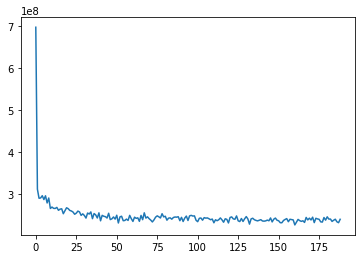

In [5]:
plt.plot(history.history['loss'])

In [6]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
for i in range(len(yy)):
  if(yy[i]-predd[i] > 99000):
    print("real value of y_test: " + str(yy[i]) + " -> the predict: " + str(predd[i]))

47/47 [==============================] - 0s 1ms/step
r_square score:  0.8894666314449334
real value of y_test: 99999.0 -> the predict: 32.36532
real value of y_test: 99999.0 -> the predict: 17.935902
real value of y_test: 99999.0 -> the predict: 18.386845


In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd)) 

RMSE:


12540.726634610197